In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from graphviz import Source
from IPython.display import display, HTML, Image
from collaborit_style import collaborit

from BEM import *
from data import get

from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline, splrep, splev
from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
import re

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Model

The following is a graphical depiction of the model, where each line represents the flow per day from each compartment to the next.

The flow from $S$ to $E$ depends on the number of individuals in each compartment, and it is what we solve for. To calculate the other flows we use the formula
$$ f_{ij} = \frac{p_{ij}}{T_{ij}}, $$
where $p_{ij}$ is the ultimate propotion of individuals that move from compartment $i$ to compartment $j$, and $T_{ij}$ is the average time (in days) it takes for an individual to move from compartment $i$ to compartment $j$.

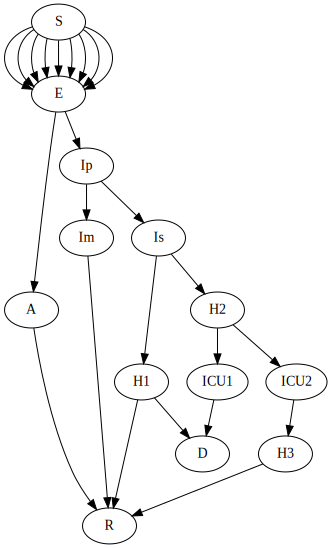

,description
compartment,
S,Susceptible
E,Exposed (not infectious)
A,"Infected, asymptomatic"
Ip,"Infected, pre-symptomatic"
Im,"Infected, mild"
Is,"Infected, severe, untreated"
H1,"Infected, severe, general ward"
H2,"Infected, severe, general ward pre-ICU"
ICU1,"Infected, severe, high care/ICU, will die"


In [3]:

MODEL = BEM()
# infections
MODEL.add_interaction('S', 'E', 'A', lambda t: 0)
MODEL.add_interaction('S', 'E', 'Ip', lambda t: 0)
MODEL.add_interaction('S', 'E', 'Im', lambda t: 0)
MODEL.add_interaction('S', 'E', 'Is', lambda t: 0)
MODEL.add_interaction('S', 'E', 'H1', lambda t: 0)
MODEL.add_interaction('S', 'E', 'H2', lambda t: 0)
MODEL.add_interaction('S', 'E', 'H3', lambda t: 0)
MODEL.add_interaction('S', 'E', 'ICU1', lambda t: 0)
MODEL.add_interaction('S', 'E', 'ICU2', lambda t: 0)
# infected compartments
MODEL.add_flow('E', 'A', lambda t: 0)
MODEL.add_flow('E', 'Ip', lambda t: 0)
MODEL.add_flow('Ip', 'Im', lambda t: 0) 
MODEL.add_flow('Ip', 'Is', lambda t: 0)
MODEL.add_flow('Is', 'H1', lambda t: 0)
MODEL.add_flow('Is', 'H2', lambda t: 0)
MODEL.add_flow('H2', 'ICU1', lambda t: 0 )
MODEL.add_flow('H2', 'ICU2', lambda t: 0 )
MODEL.add_flow('ICU2', 'H3', lambda t: 0)
# removed compartments
MODEL.add_flow('A', 'R', lambda t: 0)
MODEL.add_flow('Im', 'R', lambda t: 0)
MODEL.add_flow('H1', 'R', lambda t: 0)
MODEL.add_flow('H3', 'R', lambda t: 0)
MODEL.add_flow('H1', 'D', lambda t: 0 )
MODEL.add_flow('ICU1', 'D', lambda t: 0)

G = MODEL.transitions
G.nodes['S']['description'] = 'Susceptible'
G.nodes['E']['description'] = 'Exposed (not infectious)'
G.nodes['A']['description'] = 'Infected, asymptomatic'
G.nodes['Ip']['description'] = 'Infected, pre-symptomatic'
G.nodes['Im']['description'] = 'Infected, mild'
G.nodes['Is']['description'] = 'Infected, severe, untreated'
G.nodes['H1']['description'] = 'Infected, severe, general ward'
G.nodes['H2']['description'] = 'Infected, severe, general ward pre-ICU'
G.nodes['H3']['description'] = 'Infected, severe, general ward post-ICU'
G.nodes['ICU1']['description'] = 'Infected, severe, high care/ICU, will die'
G.nodes['ICU2']['description'] = 'Infected, severe, high care/ICU, will recover'
G.nodes['R']['description'] = 'Removed (non-infectious/discharged)'
G.nodes['D']['description'] = 'Died'

pydot = nx.nx_pydot.to_pydot(G)
pydot.set_graph_defaults()#rankdir = "LR"
display(Source(pydot))

descriptions = []
for n,d in G.nodes.data():
    descriptions.append([n,d['description']])
descriptions = pd.DataFrame(descriptions,columns=['compartment','description'])
descriptions = descriptions.set_index('compartment')
descriptions

# Flow propotions

Here we will calculate the ultimate propotions of individuals that flow from one compartment to the next.

First notice that if a compartment has only one target, then the proportion from this compartment to the target is $1$.

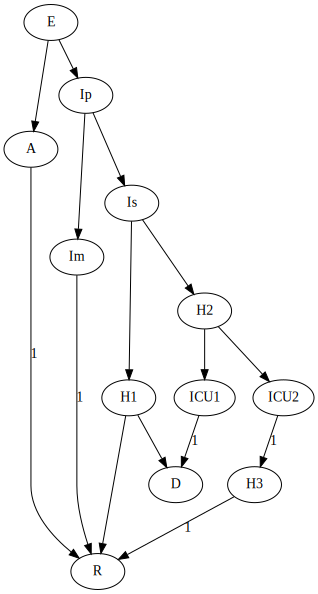

In [4]:
P = G.copy()
P.remove_node('S')
for node,out_degree in P.out_degree():
    if out_degree == 1:
        for succ in P.successors(node):
            P.edges[node,succ,0]['label'] = 1
            P.edges[node,succ,0]['mean'] = 1
            P.edges[node,succ,0]['low'] = 1
            P.edges[node,succ,0]['high'] = 1
# for source in self.transitions.edges(data=True):
pydot = nx.nx_pydot.to_pydot(P)
pydot.set_graph_defaults()#rankdir = "LR"
display(Source(pydot))

We shall now look in the literature to determine the values of the remaining edges, i.e., we have to fill in the propotions in the following binary tree.

Notice that the propotions in each split must sum to $1$, so we only have to determine $5$ values.

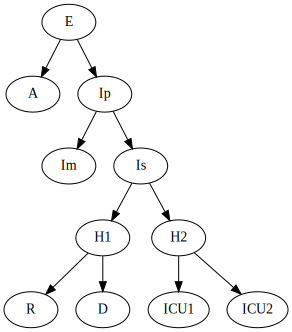

In [5]:
S = P.copy()
S.remove_edges_from([(s,t) for s,t,d in P.edges.data() if 'label' in d])
S.remove_nodes_from([n for n,d in S.degree() if d==0])
pydot = nx.nx_pydot.to_pydot(S)
pydot.set_graph_defaults()#rankdir = "LR"
display(Source(pydot))

## E to A (proportion of infected individuals that are asymptomatic)

Regarding the model, the definition of asymptomatic (in the South African context, is someone who is infected, but will not be tested.



Cases from the Cruise Ship “Diamond Princess”
- Source: https://doi.org/10.1148/ryct.2020200110
- Date: Mar 17
- Sample Size: 104 cases
- Values: 73%

Universal Screening for SARS-CoV-2 in Women Admitted for Delivery
- Source: https://doi.org/10.1056/NEJMc2009316
- Date: May 28
- Sample Size: 33 cases
- Values: 87.6%

China figures
- Source: https://doi.org/10.1136/bmj.m1375
- Date: April 2
- Sample Size: 166 cases
- Values: 78%

ZA model based on the above three references
- Source: https://www.nicd.ac.za/wp-content/uploads/2020/05/SACMC_19052020_slides-for-MoH-media-briefing.pdf
- Date: May 19
- Values: 75%

Japan evacuation
- Source: https://doi.org/10.1016/j.ijid.2020.03.020
- Date: April 22
- Sample Size: 565 tests
- Values: 30.8% (7.7%–53.8%)

Among children in China
- Source: https://doi.org/10.1542/peds.2020-0702
- Date: June
- Sample Size: 2135 cases
- Values: 94 (4.4%), 1088 (51.0%), and 826 (38.7%) cases were diagnosed as asymptomatic, mild, or moderate


https://www.eurosurveillance.org/content/10.2807/1560-7917.ES.2020.25.10.2000180

https://doi.org/10.1101/2020.03.05.20030502

https://time.com/5848949/covid-19-asymptomatic-spread/

- Source: https://www.medicalbrief.co.za/archives/up-to-45-of-covid-infections-may-be-asymptomatic-scripps-analysis/

https://www.upi.com/Health_News/2020/06/13/Most-asymptomatic-COVID-19-cases-stay-that-way-small-study-says/5301591994581/

https://www.usnews.com/news/health-news/articles/2020-05-28/studies-detail-rates-of-asymptomatic-cases-of-coronavirus



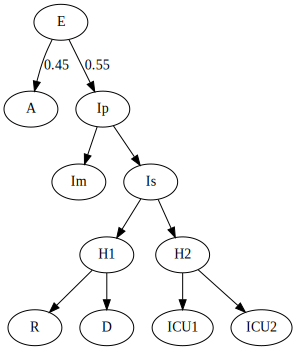

In [6]:
for graph in [S,P]:
    graph.edges['Ip','Is',0]['confidence'] = 'medium'
    graph.edges['E','A',0]['mean'] = 0.45
    graph.edges['E','A',0]['low'] =  0.32
    graph.edges['E','A',0]['high'] = 0.50
    graph.edges['E','A',0]['label'] = graph.edges['E','A',0]['mean']
    graph.edges['E','Ip',0]['label'] = 1-graph.edges['E','A',0]['label']

pydot = nx.nx_pydot.to_pydot(S)
pydot.set_graph_defaults()#rankdir = "LR"
display(Source(pydot))

## Ip to Is (proportion of symptomatic individuals that have severe symptoms)

Regarding the model, an individual is lableled as severe if they need to spend time in the hospital.

This proportion depends significantly on age.




The following demographics was obtained from the World Bank Api.

0-9      19.52%
10-19    17.16%
20-29    17.77%
30-39     17.2%
40-49    11.28%
50-59     8.04%
60-69     5.37%
70-79     2.63%
80-       1.03%
Name: ZA Demographics, dtype: object

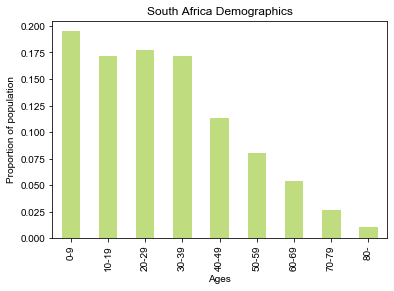

In [7]:
ZA, info = get('South Africa')
demographics = info['demographics']

demographics = pd.Series(demographics,name="ZA Demographics")
demographics = demographics/demographics.sum()
ax = demographics.plot(kind='bar')
ax.set_title('South Africa Demographics')
ax.set_xlabel('Ages')
ax.set_ylabel('Proportion of population')
demographics.mul(100).round(2).astype(str).add('%')

The current model is based on the NICD model. 
- Source: https://www.nicd.ac.za/wp-content/uploads/2020/05/SACMC_19052020_slides-for-MoH-media-briefing.pdf and https://www.nicd.ac.za/wp-content/uploads/2020/05/SACovidModellingReport_NationalLongTermProjections_Final-1.pdf
- Date: May 19
- Values: 4% (3.62%–5.09%)

The following table from their slideshow 

![alt text](images/NICD-hospitalizations.png "NICD hospitalizations")

From this they conclude that of the symptomatic population 96% are mild, 2.8% are severe, and 1.2% are critical. Thus, the proportion of symptomatic individuals that have severe symptoms is 2.8% + 1.2% = 4%. (We shall deal with the propotion of severe individuals in the next section.)

,Severe cases (hospitalized) of confirmed cases,Critical (of severe),Fatal (of critical)
Ages,,,
0-9,2.0%,0.0%,0.0%
10-19,2.0%,0.0%,0.0%
20-29,10.0%,12.0%,5.0%
30-39,15.0%,16.0%,5.0%
40-49,21.0%,19.0%,7.0%
50-59,25.0%,23.0%,17.0%
60-69,31.0%,25.0%,28.0%
70-79,40.0%,30.0%,34.0%
80-,47.0%,30.0%,83.0%


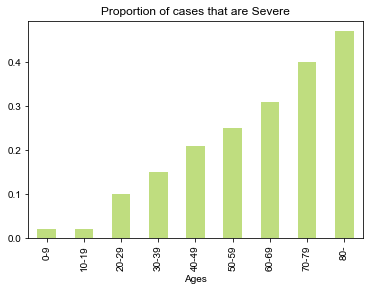

In [8]:
# table from https://www.nicd.ac.za/wp-content/uploads/2020/05/SACMC_19052020_slides-for-MoH-media-briefing.pdf
nicd = """Ages,Severe cases (hospitalized) of confirmed cases,Critical (of severe),Fatal (of critical)
0 to 9,2%,0%,0%
10 to 19,2%,0%,0%
20 to 29,10%,12%,5%
30 to 39,15%,16%,5%
40 to 49,21%,19%,7%
50 to 59,25%,23%,17%
60 to 69,31%,25%,28%
70 to 79,40%,30%,34%
80+,47%,30%,83%"""
nicd = [ row.split(',') for row in nicd.split('\n')]
nicd = pd.DataFrame(nicd[1:], columns=nicd[0])
nicd = nicd.set_index('Ages')
ages = re.compile(r'(\d+) to (\d+)')
eigty = re.compile(r'(\d+)')
def my_format(x):
    m = ages.search(x)
    if m:
        return "{}-{}".format(m.group(1),m.group(2))
    else:
        m = eigty.search(x)
        return "{}-".format(m.group(1))
nicd.index = nicd.index.map(my_format)
nicd = nicd.applymap(lambda x: float(x[:-1])/100)
ages = re.compile(r'(\d+)-(\d+)')
def mean_age(x):
    m = ages.search(x)
    if m:
        return (float(m.group(1))+float(m.group(2)))/2
    else:
        return 90.0
nicd['Age'] = nicd.index.map(mean_age)
ax = nicd.loc[:,'Severe cases (hospitalized) of confirmed cases'].plot(kind='bar')
ax.set_title('Proportion of cases that are Severe')
nicd.loc[:,[
    'Severe cases (hospitalized) of confirmed cases',
    'Critical (of severe)',
    'Fatal (of critical)'
]].mul(100).round(2).astype(str).add('%')

If one assumes that the proportion of infected people that become symptomatic is independent of age, then the underlying demographics of the sympomatics resembles that of the country. So we can calculate the effective proportion using the following formula:
$$ \sum_{i \in \text{Age group}} \text{severe%}_i \times \text{demographics%}_i$$
Alternatively, this can viewed as the dot-product of the vectors $\vec{s}$ and $\vec{d}$, where $\vec{s}$ is the percentage of severe cases and $\vec{d}$ is the pecentage of the population. If one does this calculation using the tables above one gets:

In [9]:
# print(sum(nicd['Severe cases (hospitalized) of confirmed cases']*demographics))
# totl = nicd.T.dot(demographics)
# totl['Severe cases (hospitalized) of confirmed cases']+totl['Critical (of severe)']
# .mul(100).round(2).astype(str).add('%')
# proportion of population severe
severe = nicd['Severe cases (hospitalized) of confirmed cases']*demographics
# # take percentage of these
# critical = nicd['Critical (of severe)']*severe
# severe_excuding_critical = (1-nicd['Critical (of severe)'])*severe
# # again
# fatal = nicd['Fatal (of critical)']*critical
# print(severe.sum(),severe_excuding_critical.sum(),critical.sum(),fatal.sum())
# I don't get their values
print('Severe proportion of symptomatics:',severe.sum()*100,'%')

Severe proportion of symptomatics: 12.669723004773118 %


This value is three times higher than the value they report to be using (4%).

According to the slides the source of the table above is a report by the American CDC:
- Source: https://doi.org/10.15585/mmwr.mm6912e2

![alt text](images/CDC-symptomatic.png "CDC hospitalizations")

Notice that this table uses different age ranges.


,confirmed ratio,Hospitalization low,Hospitalization,Hospitalization high,ICU admission low,ICU admission,ICU admission high,Case-fatality low,Case-fatality,Case-fatality high
Ages,,,,,,,,,,
0-19,5.02%,1.6%,2.05%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
20-44,28.79%,14.3%,17.55%,20.8%,2.0%,3.1%,4.2%,0.1%,0.15%,0.2%
45-54,17.52%,21.2%,24.75%,28.3%,5.4%,7.9%,10.4%,0.5%,0.65%,0.8%
55-64,17.52%,20.5%,25.3%,30.1%,4.7%,7.95%,11.2%,1.4%,2.0%,2.6%
65-74,16.7%,28.6%,36.05%,43.5%,8.1%,13.45%,18.8%,2.7%,3.8%,4.9%
75-84,8.57%,30.5%,44.6%,58.7%,10.5%,20.75%,31.0%,4.3%,7.4%,10.5%
85-,5.88%,31.3%,50.8%,70.3%,6.3%,17.65%,29.0%,10.4%,18.85%,27.3%


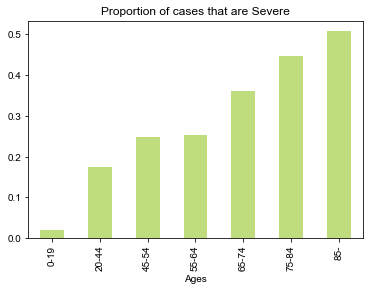

In [10]:
cdc = """Age group (yrs) (no. of cases)	Hospitalization	ICU admission	Case-fatality
0–19 (123)	1.6–2.5	0	0
20–44 (705)	14.3–20.8	2.0–4.2	0.1–0.2
45–54 (429)	21.2–28.3	5.4–10.4	0.5–0.8
55–64 (429)	20.5–30.1	4.7–11.2	1.4–2.6
65–74 (409)	28.6–43.5	8.1–18.8	2.7–4.9
75–84 (210)	30.5–58.7	10.5–31.0	4.3–10.5
≥85 (144)	31.3–70.3	6.3–29.0	10.4–27.3"""
cdc = [row.split('\t') for row in cdc.split('\n')]
cdc = pd.DataFrame(cdc[1:],columns=cdc[0])
# cdc = cdc.set_index('Age group (yrs) (no. of cases)')
ages = re.compile(r'(\d+)–(\d+)')
eigty = re.compile(r'≥(\d+)')
def ranges(x):
    m = ages.search(x)
    if m:
#         print(m.group(0))
        return "{}-{}".format(m.group(1),m.group(2))
    else:
        m = eigty.search(x)
#         print(m.group(0))
        return "{}-".format(m.group(1))
cdc['Ages'] = cdc['Age group (yrs) (no. of cases)'].apply(ranges)
cdc = cdc.set_index('Ages')

ages = re.compile(r'(\d+)-(\d+)')
def mean_age(x):
    m = ages.search(x)
    if m:
        return (float(m.group(1))+float(m.group(2)))/2
    else:
        return 90.0
cdc['Age'] = cdc.index.map(mean_age)

confirmed = re.compile(r'\((\d+)\)')
def c(x):
    m = confirmed.search(x)
    return int(m.group(1))
cdc['confirmed'] = cdc['Age group (yrs) (no. of cases)'].apply(c)
cdc['confirmed ratio'] = cdc['confirmed']/ (cdc['confirmed'].sum())
low = re.compile(r'(\d+\.\d+)–')
def low_fun(x):
    m = low.search(x)
    if m:
        return float(m.group(1))/100
    else:
        return float(x)
high = re.compile(r'–(\d+\.\d+)')
def high_fun(x):
    m = high.search(x)
    if m:
        return float(m.group(1))/100
    else:
        return float(x)
    
cdc['Hospitalization low'] = cdc['Hospitalization'].apply(low_fun)
cdc['Hospitalization high'] = cdc['Hospitalization'].apply(high_fun)
cdc['Hospitalization'] = (cdc['Hospitalization low']+cdc['Hospitalization high'])/2
cdc['ICU admission low'] = cdc['ICU admission'].apply(low_fun)
cdc['ICU admission high'] = cdc['ICU admission'].apply(high_fun)
cdc['ICU admission'] = (cdc['ICU admission low']+cdc['ICU admission high'])/2
cdc['Case-fatality low'] = cdc['Case-fatality'].apply(low_fun)
cdc['Case-fatality high'] = cdc['Case-fatality'].apply(high_fun)
cdc['Case-fatality'] = (cdc['Case-fatality low']+cdc['Case-fatality high'])/2
ax = cdc['Hospitalization'].plot(kind='bar')
ax.set_title('Proportion of cases that are Severe')
cdc.loc[:,['confirmed ratio',
           'Hospitalization low',
           'Hospitalization',
           'Hospitalization high',
           'ICU admission low',
           'ICU admission',
           'ICU admission high',
           'Case-fatality low',
           'Case-fatality',
           'Case-fatality high'
          ]].mul(100).round(2).astype(str).add('%')

We fit a line through the CDC table, and compare it the NICD table. 

R^2 score between fitted line and NICD: 0.9791877875693105


,Severe cases (hospitalized) of confirmed cases,Hospilatized Fit
Ages,,
0-9,0.02,-0.012530
10-19,0.02,0.046093
20-29,0.10,0.104716
30-39,0.15,0.163340
40-49,0.21,0.221963
50-59,0.25,0.280586
60-69,0.31,0.339209
70-79,0.40,0.397832
80-,0.47,0.488698


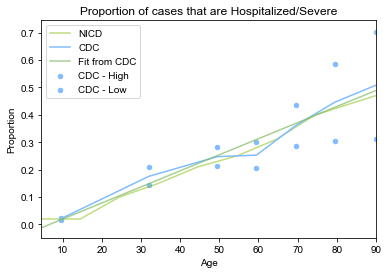

In [11]:
ax = plt.gca()
nicd.plot(x='Age',y='Severe cases (hospitalized) of confirmed cases',ax=ax)
cdc.plot(x='Age',y='Hospitalization',ax=ax)
cdc.plot(x='Age',y='Hospitalization high',kind='scatter',color=collaborit(1),ax=ax)
cdc.plot(x='Age',y='Hospitalization low',kind='scatter',color=collaborit(1),ax=ax)


lm = linear_model.LinearRegression()
lm.fit(cdc['Age'].values.reshape(cdc['Age'].shape[0], 1),cdc['Hospitalization'].values.reshape(cdc['Age'].shape[0], 1))
print('R^2 score between fitted line and NICD:',lm.score(nicd['Age'].values.reshape(nicd['Age'].shape[0], 1),nicd['Severe cases (hospitalized) of confirmed cases'].values.reshape(nicd['Age'].shape[0], 1)))
pred = lm.predict(nicd['Age'].values.reshape(nicd['Age'].shape[0], 1))
pred = pd.Series(pred.T[0],name="Hospilized fit",index=nicd['Age'])
pred.plot(ax=ax)
ax.legend(['NICD','CDC','Fit from CDC','CDC - High','CDC - Low'])
ax.set_ylabel('Proportion')
ax.set_title('Proportion of cases that are Hospitalized/Severe')
nicd['Hospilatized Fit'] = pred.values
nicd.loc[:,['Severe cases (hospitalized) of confirmed cases','Hospilatized Fit']]

A better strategy is divide value of each age range equally into a new age range of 5 year, and then recombine.

In [12]:
ages = re.compile(r'(\d+)-(\d+)')
def five(x):
    m = ages.search(x)
    if m:
        return (float(m.group(2))-float(m.group(1))+1)/5
    else:
        return (100-85)/5
def min_age(x):
    m = ages.search(x)
    if m:
        return float(m.group(1))
    else:
        return 85
assert cdc['confirmed ratio'].sum() == 1, cdc['confirmed ratio'].sum()
cdc5 = cdc.copy()
cdc5 = cdc5.drop(columns=['Age group (yrs) (no. of cases)','Age'])
cdc5.index = cdc.index.map(min_age)
buckets = cdc.index.map(five)
# cdc5 = cdc5.div(buckets,axis=0)
cdc5['confirmed'] = cdc5['confirmed']/buckets
cdc5['confirmed ratio'] = cdc5['confirmed ratio']/buckets
cdc5 = cdc5.reindex(range(0,100,5))
cdc5 = cdc5.fillna(method='ffill')
cdc5
assert cdc5['confirmed ratio'].sum() == 1, cdc5['confirmed ratio'].sum()
cdc_fit = []
s = []
for i,age_range in enumerate(nicd.index):
    m = ages.search(age_range)
    if m:
        mi,ma = int(m.group(1)),int(m.group(2))
        
    else:
        mi,ma = 80,99
    s.append( (ma-mi+1)/5 )
    cdc_fit.append(cdc5.loc[mi:ma,:].mean())
s = np.array(s)
cdc_fit = pd.DataFrame(cdc_fit,index=nicd.index,columns=cdc5.columns)
cdc_fit['confirmed'] = cdc_fit['confirmed']*s
cdc_fit['confirmed ratio'] = cdc_fit['confirmed ratio']*s
assert abs(cdc_fit['confirmed ratio'].sum() - 1) < 1e-9, cdc_fit['confirmed ratio'].sum()

# both=pd.DataFrame([],index=nicd.index)
# both['New CDC'] = cdc_fit['Hospitalization']
# both['NICD'] = nicd['Severe cases (hospitalized) of confirmed cases']
# both.plot(kind='bar')
# print('R^2 score between expanded CDC and NICD:',metrics.r2_score(cdc_fit['Hospitalization'],nicd['Severe cases (hospitalized) of confirmed cases']))

# cdc_fit

It does look like the table above is derived from the CDC source (and its values are more appropriate than the line fit, as it does not have negative values). But it still seems that the values they chose is not derived from there.

We can use the case data from this report to interigate the assumption that the symptomatic demography looks similar to the population demography.

0-9      12.26%
10-19    12.95%
20-29    14.12%
30-39    13.24%
40-49    12.33%
50-59    13.14%
60-69    11.36%
70-79     6.72%
80-       3.88%
Name: US Demographics, dtype: object

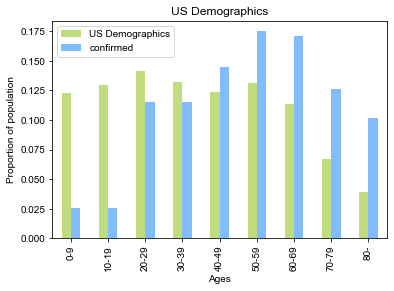

In [13]:
df, info = get('US')
US_demographics = info['demographics']

US_demographics = pd.Series(US_demographics,name="US Demographics")
US_demographics = US_demographics/US_demographics.sum()
both = pd.DataFrame([],index=US_demographics.index)
both['US Demographics'] = US_demographics
both['confirmed'] = cdc_fit['confirmed ratio']
ax = both.plot(kind='bar')
ax.set_title('US Demographics')
ax.set_xlabel('Ages')
ax.set_ylabel('Proportion of population')
US_demographics.mul(100).round(2).astype(str).add('%')
# cdc.plot(x='Age',y='confirmed ratio',kind='scatter')

Q: What is the right way to correct for this?

According to the pdf that is associated to the slides, they get their values from https://doi.org/10.1016/S1473-3099(20)30243-7 from Imperial Collage instead of the CDC site. (This is citation [5] in the following image.)

![NICD symptomatics](images/NICD-symptomatic.png)
![IC symptomatics](images/IC-hospitalizations.png)
This paper made their raw data available at https://github.com/mrc-ide/COVID19_CFR_submission


hospitalization ratio,mean,5%,95%,naive
"Age group, years",,,,
0-9,0.0%,0.0%,0.0%,0.0%
10-19,0.04%,0.02%,0.08%,2.0%
20-29,1.04%,0.62%,2.13%,11.21%
30-39,3.43%,2.04%,7.0%,16.92%
40-49,4.25%,2.53%,8.68%,20.73%
50-59,8.16%,4.86%,16.7%,28.1%
60-69,11.8%,7.01%,24.0%,35.89%
70-79,16.6%,9.87%,33.8%,50.57%
80-,18.4%,11.0%,37.6%,67.11%


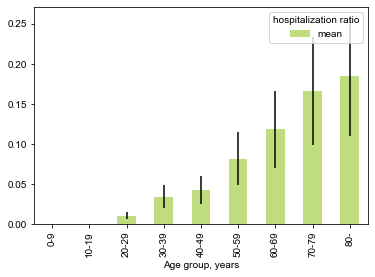

In [14]:
# symptomatic hospitalization ratio
src = """Age group, years	Severe cases	All cases	Proportion of infected individuals hospitalised
0–9 years	0	13	0·00% (0·00–0·00)
10–19 years	1	50	0·0408% (0·0243–0·0832)
20–29 years	49	437	1·04% (0·622–2·13)
30–39 years	124	733	3·43% (2·04–7·00)
40–49 years	154	743	4·25% (2·53–8·68)
50–59 years	222	790	8·16% (4·86–16·7)
60–69 years	201	560	11·8% (7·01–24·0)
70–79 years	133	263	16·6% (9·87–33·8)
≥80 years	51	76	18·4% (11·0–37·6)"""
src = src.replace('·','.')
src = src.replace('%','%')
data = [ line.split('\t') for line in src.split('\n')]
df = pd.DataFrame(data[1:],columns=data[0])
df = df.set_index('Age group, years')
df['Severe cases'] = df['Severe cases'].apply(int)
df['All cases'] = df['All cases'].apply(int)

r = re.compile(r'(\d+\.\d+)%\s+\((\d+\.\d+)–(\d+\.\d+)\)')
def ranges(inf):
#     print(inf)
    m = r.search(inf)
#     print(m.group(0))
    return np.array([float(m.group(1))/100,float(m.group(2))/100,float(m.group(3))/100])
ic = pd.DataFrame(df['Proportion of infected individuals hospitalised'].apply(ranges).tolist(),index=df.index,columns=['mean','5%','95%'])
ic['naive'] = df['Severe cases']/df['All cases']
ic

r = re.compile(r'(\d*)[–≥](\d+)\s+years')
def ranges(ages):
    m = r.search(ages)
    f,t = m.group(1),m.group(2)
    if f == '':
        f = t
        t = ''
    return "{}-{}".format(f,t)
#     return np.array([float(m.group(1)),float(m.group(2))/100,float(m.group(3))/100])
ic = ic.set_index(ic.index.map(ranges))
ic.columns = ic.columns.rename('hospitalization ratio')

err = [ 
    (ic['mean']-ic['5%']).abs(), 
    (ic['mean']-ic['95%']).abs()
]
ic.loc[:,['mean']].plot(kind='bar',yerr=err)#
ic.mul(100).round(2).astype(str).add('%')

R^2 score between naive and NICD these is: 0.859486734721682


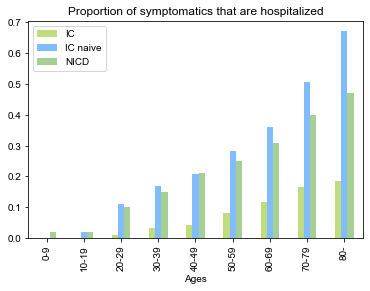

In [15]:
# compare
ax = plt.gca()
both = pd.DataFrame([],index = nicd.index)
both['IC'] = ic['mean']
both['IC naive'] = ic['naive']
both['NICD'] = nicd['Severe cases (hospitalized) of confirmed cases']
# ic['mean'].plot(kind='bar',ax=ax)
# nicd['Severe cases (hospitalized) of confirmed cases'].plot(kind='bar',color=collaborit(1),ax=ax)
both.plot(kind='bar',ax=ax)
ax.set_title('Proportion of symptomatics that are hospitalized')
# ax.legend(['Imperial collage','NICD'])
print('R^2 score between naive and NICD these is:',metrics.r2_score(ic['naive'],nicd['Severe cases (hospitalized) of confirmed cases']))

In [16]:
# print(sum(nicd['Severe cases (hospitalized) of confirmed cases']*demographics))
# totl = ic.T.dot(demographics)
# totl['Severe cases (hospitalized) of confirmed cases']+totl['Critical (of severe)']
# .mul(100).round(2).astype(str).add('%')
# proportion of population severe
severe = ic['mean']*demographics
severe_low = ic['5%']*demographics
severe_high = ic['95%']*demographics
print('Excpected hospitalized from symptomatics:',severe.sum()*100, '%', '(',severe_low.sum()*100,'% ,',severe_high.sum()*100,'% )')
# This is at least in the right order

Excpected hospitalized from symptomatics: 3.1767850306677907 % ( 1.890899423925334 % , 6.483156417348732 % )


This value as is least the same order as the pdf (4%). 

Updated CDC information:

The CDC host up to date information at https://www.cdc.gov/coronavirus/2019-ncov/covid-data/covidview/index.html, from where one can get csv's of the testing and hospitalizations.


According to https://www.nicd.ac.za/covid-19-update-48/ the (cummulative) number of Hospitalizations was 411 on 2 May in South Africa. This was 5% of confirmed cases.

![ZA hospitalizations 2 Mei](images/ZA-hospitalizations-05-02.png)

Since then the NICD has released weekly and daily epidemiological and hospitalization reports at https://www.nicd.ac.za/diseases-a-z-index/covid-19/surveillance-reports/. We'll look at the latest (13 June): 
- https://www.nicd.ac.za/wp-content/uploads/2020/06/COVID19-Daily-Report-National-Public-15June2020.pdf
- https://www.nicd.ac.za/wp-content/uploads/2020/06/NICD-Weekly-Epidemiological-Brief_-Week-ending-13-June-2020-final.pdf
- https://www.nicd.ac.za/wp-content/uploads/2020/06/NICD-COVID-19-Daily-Sentinel-Hospital-Surveillance-report-National-20200615.pdf 
- https://www.nicd.ac.za/wp-content/uploads/2020/06/NICD-COVID-19-Weekly-Sentinel-Hospital-Surveillnace-update-Week-24-2020-Final.pdf. 

Cases:
![ZA confirmed 13 June](images/ZA-confirmed-06-13.png)

,Cases,New cases,New cases proportion,Population,Cases proportion,Demographics
Ages,,,,,,
0-9,1804.0,558.0,0.026,11471385.0,0.025881,0.195174
10-19,2969.0,1000.0,0.046,10087904.0,0.042595,0.171636
20-29,13005.0,3696.0,0.170,10442757.0,0.186577,0.177673
30-39,19241.0,5815.0,0.268,10109138.0,0.276043,0.171997
40-49,14938.0,4675.0,0.215,6631025.0,0.214309,0.112820
50-59,10244.0,3471.0,0.160,4727560.0,0.146966,0.080435
60-69,4557.0,1515.0,0.070,3154597.0,0.065377,0.053672
70-79,1862.0,580.0,0.027,1547686.0,0.026713,0.026332
80-,1083.0,342.0,0.016,602969.0,0.015537,0.010259


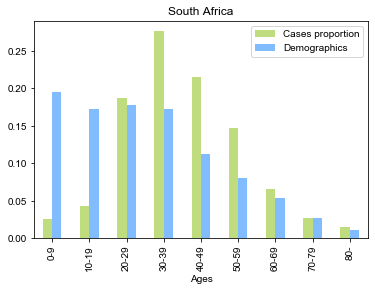

In [17]:
columns = [
    "Age group (years)",
    "Cases", 
    "New cases",
    "New cases proportion",
    "Population",
    "Incidence risk (cases per 100000 persons)",
    "Change in incidence risk (cases /100 1000 persons), week 24 vs. week 23"
]
data = """0-4 928 273 (1.3) 5733946 16.2 1.4
5-9 876 285 (1.3) 5737439 15.3 1.8
10-14 1220 419 (1.9) 5427902 22.5 3.2
15-19 1749 581 (2.7) 4660002 37.5 4.3
20-24 4601 1302 (6.0) 4914186 93.6 4.9
25-29 8404 2394 (11.0) 5528571 152.0 8.8
30-34 9694 2907 (13.4) 5537963 175.0 14.2
35-39 9547 2908 (13.4) 4571175 208.9 18.8
40-44 7985 2457 (11.3) 3585408 222.7 18.2
45-49 6953 2218 (10.2) 3045617 228.3 21.7
50-54 5765 1934 (8.9) 2535048 227.4 24.0
55-59 4479 1537 (7.1) 2192512 204.3 26.0
60-64 2814 974 (4.5) 1784476 157.7 19.8
65-69 1743 541 (2.5) 1370121 127.2 8.8
70-74 1123 361 (1.7) 949812 118.2 11.1
75-79 739 219 (1.0) 597874 123.6 7.9
80- 1083 342 (1.6) 602969 179.6 8.1"""
data = [ row.split(' ') for row in data.split('\n')]
nicd_cases = pd.DataFrame(data,columns=columns)
nicd_cases = nicd_cases.set_index("Age group (years)")
nicd_cases["Cases"] = nicd_cases["Cases"].apply(int)
nicd_cases["New cases"] = nicd_cases["New cases"].apply(int)
nicd_cases["New cases proportion"] = nicd_cases["New cases proportion"].apply(lambda x: float(x[1:-1])/100)
nicd_cases["Population"] = nicd_cases["Population"].apply(int)
nicd_cases = nicd_cases.drop(columns=["Incidence risk (cases per 100000 persons)",    "Change in incidence risk (cases /100 1000 persons), week 24 vs. week 23"])
nicd_fit = []
ages = re.compile(r'(\d+)-(\d+)')
for i,age_range in enumerate(nicd.index):
    m = ages.search(age_range)
    if m:
        mi,ma = int(m.group(1)),int(m.group(2))
        nicd_fit.append(nicd_cases.loc["{}-{}".format(mi,mi+4),:]+nicd_cases.loc["{}-{}".format(mi+5,mi+9),:])
    else:
        nicd_fit.append(nicd_cases.loc["80-",:])
    
nicd_fit = pd.DataFrame(nicd_fit,index=nicd.index,columns=nicd_cases.columns)
nicd_fit['Cases proportion'] = nicd_fit['Cases']/nicd_fit['Cases'].sum()
nicd_fit['Demographics'] = nicd_fit['Population']/nicd_fit['Population'].sum()

ax = nicd_fit.loc[:,['Cases proportion','Demographics']].plot(kind='bar')
ax.set_title('South Africa')

nicd_fit

![ZA hospitalizations 13 June](images/ZA-hospitalizations-06-13.png)

Ages
0-9      0.110310
10-19    0.040418
20-29    0.058131
30-39    0.080401
40-49    0.113201
50-59    0.181082
60-69    0.275839
70-79    0.392052
80-      0.353647
Name: hospitalizations proportion, dtype: float64

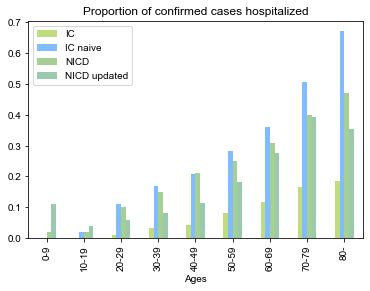

In [18]:
nicd_hos = pd.Series([199,120,756,1547,8688-150-(199+120+756+1547+1855+1257+730+383),1855,1257,730,383],index=nicd.index)
nicd_fit['hospitalizations'] = nicd_hos
nicd_fit['hospitalizations proportion'] = nicd_fit['hospitalizations']/nicd_fit['Cases']


both = pd.DataFrame([],index = nicd.index)
both['IC'] = ic['mean']
both['IC naive'] = ic['naive']
both['NICD'] = nicd['Severe cases (hospitalized) of confirmed cases']
both['NICD updated'] = nicd_fit['hospitalizations proportion']
# ic['mean'].plot(kind='bar',ax=ax)
# nicd['Severe cases (hospitalized) of confirmed cases'].plot(kind='bar',color=collaborit(1),ax=ax)
ax = both.plot(kind='bar')
ax.set_title('Proportion of confirmed cases hospitalized')

nicd_fit['hospitalizations proportion']

In [19]:
severe = nicd_fit['Cases proportion']*nicd_fit['hospitalizations proportion']
print("Proporiton of confirmed cases hospitalized (NICD updated):",severe.sum()*100,'%')
print("IC:",(nicd_fit['Cases proportion']*ic['mean']).sum()*100,'%')
print("IC naive:",(nicd_fit['Cases proportion']*ic['naive']).sum()*100,'%')
print("NICD:",(nicd_fit['Cases proportion']*nicd['Severe cases (hospitalized) of confirmed cases']).sum()*100,'%')

Proporiton of confirmed cases hospitalized (NICD updated): 12.249114098388878 %
IC: 4.753446841599357 %
IC naive: 20.159006192564505 %
NICD: 18.14350888770928 %


This is based of the demographics of the confirmed cases, and not the country's demographics.

Possibly 15%.

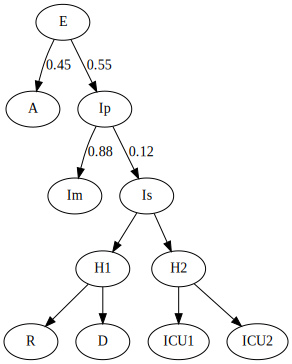

In [20]:
for graph in [S,P]:
    graph.edges['Ip','Is',0]['confidence'] = 'low'
    graph.edges['Ip','Is',0]['mean'] = 0.12
    graph.edges['Ip','Is',0]['low'] =  0.05
    graph.edges['Ip','Is',0]['high'] = 0.20
    graph.edges['Ip','Is',0]['label'] = graph.edges['Ip','Is',0]['mean']
    graph.edges['Ip','Im',0]['label'] = 1-graph.edges['Ip','Is',0]['label']

pydot = nx.nx_pydot.to_pydot(S)
pydot.set_graph_defaults()#rankdir = "LR"
display(Source(pydot))

## Is to H2 (proportion of severe [hospitalized] people that go to ICU)

For the mine ICU means oxigen (cpap) + ventilation.

The NICD daily report
- Source: https://www.nicd.ac.za/wp-content/uploads/2020/06/NICD-COVID-19-Daily-report-National-20200616.pdf
- Date: 13 June
- Values: (23.8% 21.8%)

![ZA ICU 06-13](images/ZA-ICU-06-13.png)
![ZA ICU 06-13](images/Province-ICU-06-13.png)

Using the currently hospitalized demographics from NICD and the Critical (of severe) proportion from the NICD model slides (based on the CDC report).

In [21]:
severe = nicd_fit['hospitalizations']/nicd_fit['hospitalizations'].sum()
print("Proportion of severe cases going to ICU:",(severe*nicd['Critical (of severe)']).sum()*100,'%')

Proportion of severe cases going to ICU: 20.31307097680956 %


This picture is again based on the CDC report, and calculated in the NICD model pdf.
![NICD symptomatics](images/NICD-symptomatic.png)
Taking the various ratios of the last two values we get:

In [22]:
1.16/(1.16+2.46),1.16/(1.16+3.64),1.45/(1.45+2.46),1.45/(1.45+3.64),

(0.3204419889502762,
 0.24166666666666667,
 0.37084398976982097,
 0.28487229862475444)

Is likely to be 

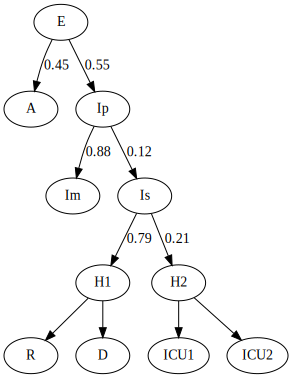

In [23]:
for graph in [S,P]:
    graph.edges['Is','H2',0]['mean'] = 0.21
    graph.edges['Is','H2',0]['low'] =  0.20
    graph.edges['Is','H2',0]['high'] = 0.23
    graph.edges['Is','H2',0]['label'] = graph.edges['Is','H2',0]['mean']
    graph.edges['Is','H1',0]['label'] = 1-graph.edges['Is','H2',0]['label']

pydot = nx.nx_pydot.to_pydot(S)
pydot.set_graph_defaults()#rankdir = "LR"
display(Source(pydot))

## H2 to ICU1 (proportion of ICU partients that die)

This is using the table from the NICD model slides.

Proportion of critical that die: 21.31946054095818 %


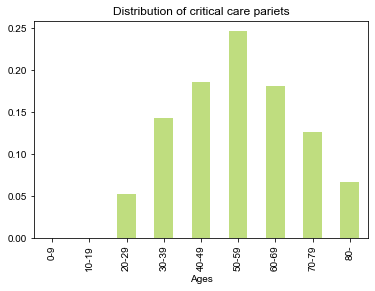

In [24]:
severe = nicd_fit['hospitalizations']/nicd_fit['hospitalizations'].sum()
critical = severe*nicd['Critical (of severe)']
critical = critical/critical.sum()
ax = critical.plot(kind='bar')
ax.set_title('Distribution of critical care pariets')
fatal = nicd['Fatal (of critical)']*critical
print('Proportion of critical that die:',fatal.sum()*100,'%')

Study of ICU patients in Britan.
- Source: https://www.icnarc.org/DataServices/Attachments/Download/b5f59585-5870-ea11-9124-00505601089b
- Date: 27 March
- Values: 60% (52% 69%)

![ICNARC deaths](images/ICNARC-deaths1.png)
![ICNARC deaths](images/ICNARC-deaths.png)

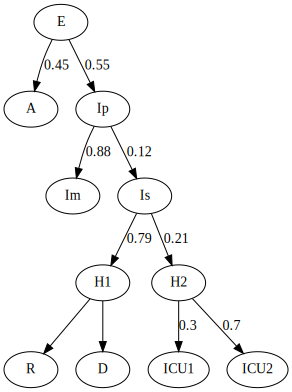

In [25]:
for graph in [S,P]:
    graph.edges['H2','ICU1',0]['confidence'] = 'low'
    graph.edges['H2','ICU1',0]['mean'] = 0.3
    graph.edges['H2','ICU1',0]['low'] =  0.213
    graph.edges['H2','ICU1',0]['high'] = 0.69
    graph.edges['H2','ICU1',0]['label'] = graph.edges['H2','ICU1',0]['mean']
    graph.edges['H2','ICU2',0]['label'] = 1-graph.edges['H2','ICU1',0]['label']

pydot = nx.nx_pydot.to_pydot(S)
pydot.set_graph_defaults()#rankdir = "LR"
display(Source(pydot))

In [26]:
e2d = P.edges['E','Ip',0]['label']*P.edges['Ip','Is',0]['mean']*P.edges['Is','H2',0]['mean']*P.edges['H2','ICU1',0]['mean']
ip2d = P.edges['Ip','Is',0]['mean']*P.edges['Is','H2',0]['mean']*P.edges['H2','ICU1',0]['mean']
is2d = P.edges['Is','H2',0]['mean']*P.edges['H2','ICU1',0]['mean']
e2h1 = P.edges['E','Ip',0]['label']*P.edges['Ip','Is',0]['mean']*P.edges['Is','H1',0]['label']
ip2h1 = P.edges['Ip','Is',0]['mean']*P.edges['Is','H1',0]['label']
is2h1 = P.edges['Is','H1',0]['label']
print("Proportion of severe that die out of ICU:",is2d*100,'%')
print("Proportion of symptomatics that die out of ICU:",ip2d*100,'%')
print("Proportion of infected that die out of ICU:",e2d*100,'%')

Proportion of severe that die out of ICU: 6.3 %
Proportion of symptomatics that die out of ICU: 0.7559999999999999 %
Proportion of infected that die out of ICU: 0.4158 %


## H1 to D (proportion of non-ICU hospitalized people that die)

We solve this using the overall death ratio and subtracting the ICU deaths from above.

The NICD daily report
- Source: https://www.nicd.ac.za/wp-content/uploads/2020/06/NICD-COVID-19-Daily-report-National-20200616.pdf
- Date: 13 June
- Values: (23.8% 21.8%)

![ZA death 06-13](images/ZA-death-06-13.png)

In [27]:
nicd_s2d = 1226/(1226+4804)
print('Percentage of severe that die:',nicd_s2d*100,'%')
print('So, proportion of non-ICU hospitalized that die:',(nicd_s2d-is2d)/is2h1*100,'%')

Percentage of severe that die: 20.33167495854063 %
So, proportion of non-ICU hospitalized that die: 17.761613871570418 %


Ages
0-9      0.000831
10-19    0.002494
20-29    0.014131
30-39    0.057357
40-49    0.133832
50-59    0.238570
60-69    0.272652
70-79    0.174564
80-      0.105569
Name: deaths ratio, dtype: float64

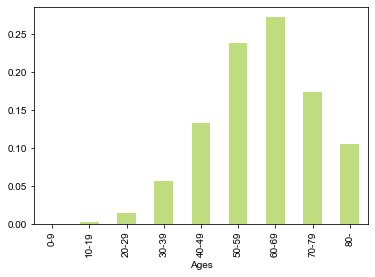

In [28]:
nicd_deaths = pd.Series([1,3,17,69,161,287,328,210,127],index=nicd.index)
nicd_fit['deaths'] = nicd_deaths
nicd_fit['deaths ratio'] = nicd_fit['deaths']/nicd_fit['deaths'].sum()
nicd_fit['deaths ratio'].plot(kind='bar')
nicd_fit['deaths ratio']

This is using the table from the NICD model slides.

Proportion of severe that die: 4.330637151557743 %
So, proportion of non-ICU hospitalized that die: -2.4928643651167817 %


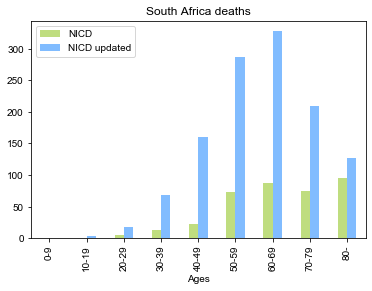

In [29]:
severe = nicd_fit['hospitalizations']/nicd_fit['hospitalizations'].sum()
critical = severe*nicd['Critical (of severe)']
fatal = nicd['Fatal (of critical)']*critical
print('Proportion of severe that die:',fatal.sum()*100,'%')

both = pd.DataFrame([],index=nicd.index)
both['NICD'] = fatal*nicd_fit['hospitalizations'].sum()
both['NICD updated'] = nicd_fit['deaths']
ax = both.plot(kind='bar')
ax.set_title('South Africa deaths')
print('So, proportion of non-ICU hospitalized that die:',(fatal.sum()-is2d)/is2h1*100,'%')


This is not reasonable.

From the Imperial Collage paper https://doi.org/10.1016/S1473-3099(20)30243-7:

![IC deaths](images/IC-deaths.png)

case fatality ratio,mean,5%,95%
"Age group, years",,,
0-9,0.0%,0.0%,0.02%
10-19,0.01%,0.0%,0.05%
20-29,0.03%,0.01%,0.09%
30-39,0.08%,0.04%,0.18%
40-49,0.16%,0.08%,0.32%
50-59,0.6%,0.34%,1.28%
60-69,1.93%,1.11%,3.89%
70-79,4.28%,2.45%,8.44%
80-,7.8%,3.8%,13.3%


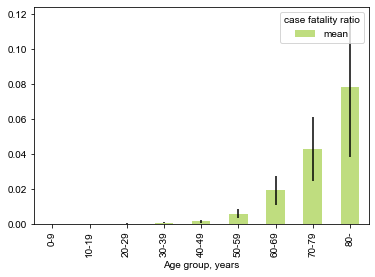

In [30]:
# case fatality ratio
src = """Age group, years	Deaths	Laboratory-confirmed cases	Crude	Adjusted for censoring	Adjusted for censoring, demography, and under-ascertainment	case fatality ratio
0–9	0	416	0·000% (0·000–0·883)	0·0954% (0·0110–1·34)	0·00260% (0·000312–0·0382)	0·00161% (0·000185–0·0249)
10–19	1	549	0·182% (0·00461–1·01)	0·352% (0·0663–1·74)	0·0148% (0·00288–0·0759)	0·00695% (0·00149–0·0502)
20–29	7	3619	0·193% (0·0778–0·398)	0·296% (0·158–0·662)	0·0600% (0·0317–0·132)	0·0309% (0·0138–0·0923)
30–39	18	7600	0·237% (0·140–0·374)	0·348% (0·241–0·577)	0·146% (0·103–0·255)	0·0844% (0·0408–0·185)
40–49	38	8571	0·443% (0·314–0·608)	0·711% (0·521–0·966)	0·295% (0·221–0·422)	0·161% (0·0764–0·323)
50–59	130	10 008	1·30% (1·09–1·54)	2·06% (1·74–2·43)	1·25% (1·03–1·55)	0·595% (0·344–1·28)
60–69	309	8583	3·60% (3·22–4·02)	5·79% (5·20–6·34)	3·99% (3·41–4·55)	1·93% (1·11–3·89)
70–79	312	3918	7·96% (7·13–8·86)	12·7% (11·5–13·9)	8·61% (7·48–9·99)	4·28% (2·45–8·44)
≥80	208	1408	14·8% (13·0–16·7)	23·3% (20·3–26·7)	13·4% (11·2–15·9)	7·80% (3·80–13·3)"""
src = src.replace('·','.')
src = src.replace('%','%')
data = [ line.split('\t') for line in src.split('\n')]
df = pd.DataFrame(data[1:],columns=data[0])
df = df.set_index('Age group, years')
r = re.compile(r'(\d+\.\d+)%\s+\((\d+\.\d+)–(\d+\.\d+)\)')
def ranges(inf):
#     print(inf)
    m = r.search(inf)
#     print(m.group(0))
    return np.array([float(m.group(1))/100,float(m.group(2))/100,float(m.group(3))/100])
case_fatality_ratio = pd.DataFrame(df['case fatality ratio'].apply(ranges).tolist(),index=df.index,columns=['mean','5%','95%'])
case_fatality_ratio

r = re.compile(r'(\d*)[–≥](\d+)')
def ranges(ages):
    m = r.search(ages)
    f,t = m.group(1),m.group(2)
    if f == '':
        f = t
        t = ''
    return "{}-{}".format(f,t)
#     return np.array([float(m.group(1)),float(m.group(2))/100,float(m.group(3))/100])
case_fatality_ratio = case_fatality_ratio.set_index(case_fatality_ratio.index.map(ranges))
case_fatality_ratio.columns = case_fatality_ratio.columns.rename('case fatality ratio')
err = [ 
    (case_fatality_ratio['mean']-case_fatality_ratio['5%']).abs(), 
    (case_fatality_ratio['mean']-case_fatality_ratio['95%']).abs()
]
case_fatality_ratio.loc[:,['mean']].plot(kind='bar',yerr=err)#
case_fatality_ratio.mul(100).round(2).astype(str).add('%')

Using overall demographics: 0.38384660669192455 %
Using confirmed demographics: 0.5130525499619816 %


0.0186521960034487

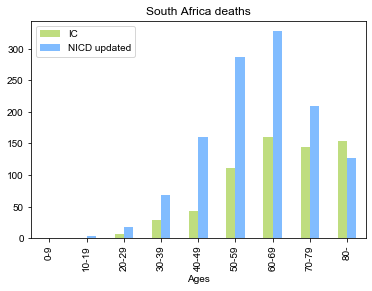

In [31]:
both = pd.DataFrame([],index=nicd.index)
both['IC'] = nicd_fit['Cases']*case_fatality_ratio['mean']/P.edges['E','Ip',0]['label']
both['NICD updated'] = nicd_fit['deaths']
ax = both.plot(kind='bar')
ax.set_title('South Africa deaths')

print('Using overall demographics:',(demographics*case_fatality_ratio['mean']).sum()*100,'%')
print('Using confirmed demographics:',(nicd_fit['Cases proportion']*case_fatality_ratio['mean']).sum()*100,'%')
((nicd_fit['Cases proportion']*case_fatality_ratio['mean']).sum()-e2d)/e2h1
# (nicd_fit['Cases proportion']*case_fatality_ratio['mean']).sum()-e2d

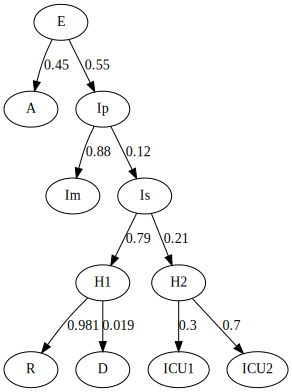

In [32]:
for graph in [S,P]:
    graph.edges['H1','D',0]['confidence'] = 'low'
    graph.edges['H1','D',0]['mean'] = 0.019
    graph.edges['H1','D',0]['low'] =  0.0
    graph.edges['H1','D',0]['high'] = 0.12
    graph.edges['H1','D',0]['label'] = graph.edges['H1','D',0]['mean']
    graph.edges['H1','R',0]['label'] = 1-graph.edges['H1','D',0]['label']

pydot = nx.nx_pydot.to_pydot(S)
pydot.set_graph_defaults()#rankdir = "LR"
display(Source(pydot))

In [33]:
print('Case fatality ratio:',(e2d+e2h1*P.edges['H1','D',0]['mean'])*100,'%')
print('Symptomatic fatality ratio:',(ip2d+ip2h1*P.edges['H1','D',0]['mean'])*100,'%')
print('Severe fatality ratio:',(is2d+is2h1*P.edges['H1','D',0]['mean'])*100,'%')

Case fatality ratio: 0.514866 %
Symptomatic fatality ratio: 0.9361199999999998 %
Severe fatality ratio: 7.800999999999999 %


# Flow periods

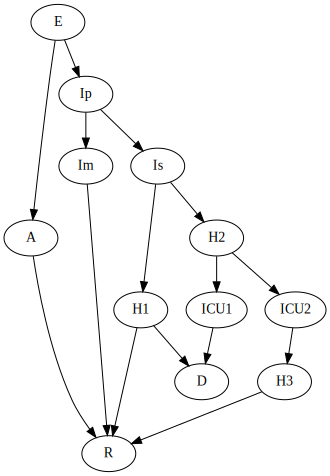

In [34]:
T = G.copy()
T.remove_node('S')

# for source in self.transitions.edges(data=True):
pydot = nx.nx_pydot.to_pydot(T)
pydot.set_graph_defaults()#rankdir = "LR"
display(Source(pydot))

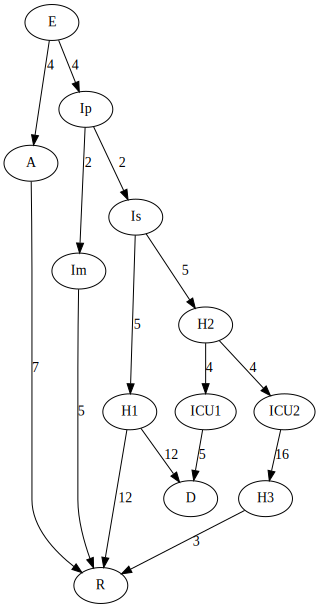

In [35]:
T.edges['E','A',0]['mean'] = 4
T.edges['E','A',0]['low'] = 2
T.edges['E','A',0]['high'] = 6
T.edges['E','Ip',0]['mean'] = 4
T.edges['E','Ip',0]['low'] = 2
T.edges['E','Ip',0]['high'] = 6

T.edges['Ip', 'Im',0]['mean'] = 2
T.edges['Ip', 'Im',0]['low'] = 1
T.edges['Ip', 'Im',0]['high'] = 3
T.edges['Ip', 'Is',0]['mean'] = 2
T.edges['Ip', 'Is',0]['low'] = 1
T.edges['Ip', 'Is',0]['high'] = 3

T.edges['Is', 'H1',0]['mean'] = 5
T.edges['Is', 'H1',0]['low'] = 4
T.edges['Is', 'H1',0]['high'] = 6
T.edges['Is', 'H2',0]['mean'] = 5
T.edges['Is', 'H2',0]['low'] = 4
T.edges['Is', 'H2',0]['high'] = 6

T.edges['H2', 'ICU1',0]['mean'] = 9 - T.edges['Is', 'H1',0]['mean']
T.edges['H2', 'ICU1',0]['low'] = 7 - T.edges['Is', 'H1',0]['low']
T.edges['H2', 'ICU1',0]['high'] = 11 - T.edges['Is', 'H1',0]['high']
T.edges['H2', 'ICU2',0]['mean'] = 9 - T.edges['Is', 'H1',0]['mean']
T.edges['H2', 'ICU2',0]['low'] = 7 - T.edges['Is', 'H1',0]['low']
T.edges['H2', 'ICU2',0]['high'] = 11 - T.edges['Is', 'H1',0]['high']

T.edges['ICU2', 'H3',0]['mean'] = 16
T.edges['ICU2', 'H3',0]['low'] = 14
T.edges['ICU2', 'H3',0]['high'] = 18


T.edges['Im', 'R',0]['mean'] = 5
T.edges['Im', 'R',0]['low'] = 4
T.edges['Im', 'R',0]['high'] = 6
T.edges['A', 'R',0]['mean'] = 5+T.edges['Ip', 'Im',0]['mean']
T.edges['A', 'R',0]['low'] = 4+T.edges['Ip', 'Im',0]['low']
T.edges['A', 'R',0]['high'] = 6+T.edges['Ip', 'Im',0]['high']

T.edges['H1', 'R',0]['mean'] = 12
T.edges['H1', 'R',0]['low'] = 8
T.edges['H1', 'R',0]['high'] = 14
T.edges['H1', 'D',0]['mean'] = 12
T.edges['H1', 'D',0]['low'] = 8
T.edges['H1', 'D',0]['high'] = 14

T.edges['H3', 'R',0]['mean'] = 3
T.edges['H3', 'R',0]['low'] = 3
T.edges['H3', 'R',0]['high'] = 3

T.edges['ICU1', 'D',0]['mean'] = 5
T.edges['ICU1', 'D',0]['low'] = 4
T.edges['ICU1', 'D',0]['high'] = 7

for s,t,d in T.edges.data():
    d['label'] = d['mean']
    
pydot = nx.nx_pydot.to_pydot(T)
pydot.set_graph_defaults()#rankdir = "LR"
display(Source(pydot))

In [36]:
# gantt chart
import plotly.figure_factory as ff
# make dataframe with Task, Start, Finish
#fig = ff.create_gantt(df)
#fig.show()

# Save

In [37]:

E = G.copy()
E.remove_node('S')
edges = []
for s,t,i in E.edges:
    d_low = {'level':'low','from':s,'to':t}
    d_mean = {'level':'mean','from':s,'to':t}
    d_high = {'level':'high','from':s,'to':t}
    try:
        d_mean['proportion']=P.edges[s,t,i]['mean']
        d_low['proportion']=P.edges[s,t,i]['low']
        d_high['proportion']=P.edges[s,t,i]['high']
    except KeyError:
        for sib in E.successors(s):
            if sib != t:
                d_mean['proportion']=1-P.edges[s,sib,i]['mean']
                d_low['proportion']=1-P.edges[s,sib,i]['low']#['high']
                d_high['proportion']=1-P.edges[s,sib,i]['high']#['low']
    d_mean['period']=T.edges[s,t,i]['mean']
    d_low['period']=T.edges[s,t,i]['low']
    d_high['period']=T.edges[s,t,i]['high']
    
    edges.append(d_mean)
    edges.append(d_low)
    edges.append(d_high)
df = pd.DataFrame(edges,columns=['level','from','to','proportion','period'])
df = df.set_index(['level','from','to'])
df.to_csv('NICD-edges.csv')
df


# for s,t in [['E','A'],['E','Ip'],['Ip', 'Im'],['Ip', 'Is'],['Is', 'H1'],['Is', 'H2'],['H2', 'ICU1'],['H2', 'ICU1'],['H2', 'ICU2'],['ICU2', 'H3'],['Im', 'R'],['A', 'R'],['H1', 'R'],['H1', 'D'],['H3', 'R'],['ICU1', 'D']]
#     pass

# 

,,,proportion,period
level,from,to,,
mean,E,A,0.450,4
low,E,A,0.320,2
high,E,A,0.500,6
mean,E,Ip,0.550,4
low,E,Ip,0.680,2
high,E,Ip,0.500,6
mean,A,R,1.000,7
low,A,R,1.000,5
high,A,R,1.000,9


# Other parameters

In [38]:
other_parameters = {}

## Asymptomatic infectiousness ratio

How much less infective are Asymptomatics? 

50%-100%

https://news.yahoo.com/people-spread-coronavirus-dont-symptoms-122213423.html

https://medicalxpress.com/news/2020-06-covid-infection-greater.html

In [39]:
other_parameters['asymptomatic infectiousness ratio'] = {'low':0.5,'mean':0.75,'high':1}
print('asymptomatic infectiousness ratio:', other_parameters['asymptomatic infectiousness ratio'])

asymptomatic infectiousness ratio: {'low': 0.5, 'mean': 0.75, 'high': 1}


## Test parameters

- Based on a [study](https://www.sciencedirect.com/science/article/pii/S1413867020300295) in brazil, the sensitivity of PCR tests for covid is 97% (85–99) and the specificity is 99% (77–100).
- Based on a [survey](http://www.statssa.gov.za/publications/Report-03-00-05/Report-03-00-052011.pdf) from 2011, we could estimate the proportion of the population with flu or ARTI symptoms as 
$$\text{Propotion ill in a month}\times\text{Proportion of ill with flu or ARTI}\times\text{Duration of illness} \,/\, \text{29 days}$$
$$ = 0.096 \times 0.637 \times 7 \,/\, 30 \approx 0.0143$$

This is just for initial values. It will be optimized.

In [40]:
other_parameters['TPR']={'mean': 0.97,'low': 0.85,'high': 0.99} 
other_parameters['TNR']={'mean': 0.99,'low': 0.77,'high': 1.0}
other_parameters['symp_prop']={'mean': 0.0143,'low': 0.001,'high': 0.06}
other_parameters['testing_delay']={'mean': 2,'low': 0,'high': 14}
print('Sensitivity:', other_parameters['TPR'],'Specificity:',other_parameters['TNR'])
print('Symptomatic Proportion:',other_parameters['symp_prop'])
print('Delay:',other_parameters['testing_delay'])

Sensitivity: {'mean': 0.97, 'low': 0.85, 'high': 0.99} Specificity: {'mean': 0.99, 'low': 0.77, 'high': 1.0}
Symptomatic Proportion: {'mean': 0.0143, 'low': 0.001, 'high': 0.06}
Delay: {'mean': 2, 'low': 0, 'high': 14}


## save

In [41]:
df = pd.DataFrame(other_parameters)
df.to_csv('NICD-other.csv')
df

,asymptomatic infectiousness ratio,TPR,TNR,symp_prop,testing_delay
low,0.50,0.85,0.77,0.0010,0
mean,0.75,0.97,0.99,0.0143,2
high,1.00,0.99,1.00,0.0600,14


# Model comparison


## Comparison with Epidemic calculator

R0: 3.335
Incubation period: 4.0
Effective infectious period: 6.67
Case fatality rate: 0.514866 %
Average time till death after incubation period: 16.57723368798872
Hospitalization rate: 6.085134000000001 %
Time till hospital: 0.33000000000000007
Length of hospital stay: 16.580606781677574
Recovery time for mild cases: 0.33000000000000007


(1, 88633.99795273162)

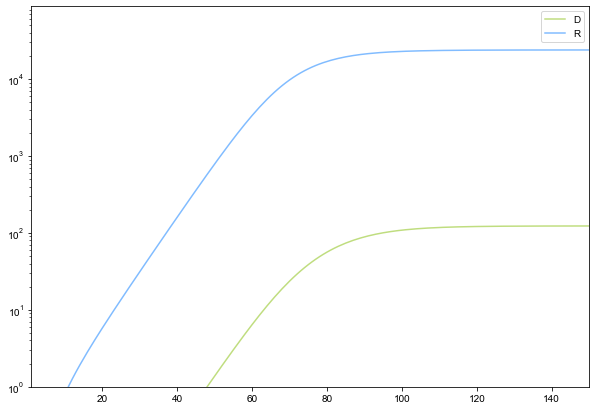

In [42]:

beta = 0.5
days = 150
N = 25000
dfe = {'S':N, 'E':0, 'A':0, 'Ip':0, 'Im':0, 'Is':0, 'H1':0, 'H2':0, 'H3':0, 'ICU1':0, 'ICU2':0, 'R':0, 'D':0}

MODEL = BEM()
# infections
MODEL.add_interaction('S', 'E', 'A', lambda t: beta)
MODEL.add_interaction('S', 'E', 'Ip', lambda t: beta)
MODEL.add_interaction('S', 'E', 'Im', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'Is', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'H1', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'H2', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'H3', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'ICU1', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'ICU2', lambda t: beta)
# infected compartments
for source,target,i in P.edges:
#     print(source,target,i)
#     f = lambda t, source=source,target=target: P.edges[source,target,0]['label']/T.edges[source,target,0]['label']
#     print(f(0))
#     v = P.edges[source,target,0]['label']/(T.edges[source,target,0]['label'])
#     MODEL.add_flow(source,target,lambda t,v=v: v)
    p = P.edges[source,target,0]['label']
    t = T.edges[source,target,0]['label']
    MODEL.add_flow(source,target, lambda time,p=p: p, lambda time,t=t: t)

print('R0:', MODEL.R0(0,dfe))

E2A_p,E2A_t = MODEL.proportion_period('E','A')
# print(E2A_p,E2A_t)
E2Ip_p,E2Ip_t = MODEL.proportion_period('E','Ip')
# print(E2Ip_p,E2Ip_t)
exposed_period = E2A_p*E2A_t+E2Ip_p*E2Ip_t
print('Incubation period:', exposed_period)
# exposed_period = P.edges['E','A',0]['label']*T.edges['E','A',0]['label']+P.edges['E','Ip',0]['label']*T.edges['E','Ip',0]['label']
A2R_p, A2R_t = MODEL.proportion_period('A','R')
Ip2Is_p, Ip2Is_t = MODEL.proportion_period('Ip','Is')
Ip2Im_p, Ip2Im_t = MODEL.proportion_period('Ip','Im')
# Ip2H1_p, Ip2H1_t = MODEL.proportion_period('Ip','H1')
# Ip2H2_p, Ip2H2_t = MODEL.proportion_period('Ip','H2')
# Ip2R_p, Ip2R_t = MODEL.proportion_period('Ip','R')
# Ip2D_p, Ip2D_t = MODEL.proportion_period('Ip','D')
Im2R_p, Im2R_t = MODEL.proportion_period('Im','R')
# infected_period = E2A_p*A2R_t+E2Ip_p*(Ip2R_t+Ip2D_t)
# infected_period = P.edges['E','A',0]['label']*(path_sum['A']['R'] + path_sum['A']['D'])+P.edges['E','Ip',0]['label']*(path_sum['Ip']['R'] + path_sum['Ip']['D'])
# infected_period = E2A_p*A2R_t+E2Ip_p*(Ip2H1_p*Ip2H1_t+Ip2H2_p*Ip2H2_t)
infected_period = E2A_p*A2R_t+E2Ip_p*(Ip2Is_p*Ip2Is_t+Ip2Im_p*(Ip2Im_t+Im2R_t))
print('Effective infectious period:', infected_period)
E2D_p,E2D_t = MODEL.proportion_period('E','D')
print('Case fatality rate:',E2D_p*100,'%')
Ip2D_p, Ip2D_t = MODEL.proportion_period('Ip','D')
# print('Average time till death after incubation period:', Ip2D_t/Ip2D_p)#(props['Ip']['D']*P.edges['E','Ip',0]['label'])
print('Average time till death after incubation period:', Ip2D_t)#(props['Ip']['D']*P.edges['E','Ip',0]['label'])
E2Is_p,E2Is_t = MODEL.proportion_period('E','Is')
Is2R_p,Is2R_t = MODEL.proportion_period('Is','R')
print('Hospitalization rate:', E2Is_p*Is2R_p*100,'%')
E2H1_p,E2H1_t = MODEL.proportion_period('E','H1')
E2H2_p,E2H2_t = MODEL.proportion_period('E','H2')
print('Time till hospital:', (E2H1_p*E2H1_t+E2H2_p*E2H2_t)/(E2H1_p+E2H2_p)-infected_period-exposed_period)
H12R_p,H12R_t = MODEL.proportion_period('H1','R')
H22R_p,H22R_t = MODEL.proportion_period('H2','R')
# H12D_p,H12D_t = MODEL.proportion_period('H1','D')
# H22D_p,H22D_t = MODEL.proportion_period('H2','D')
print('Length of hospital stay:', (H12R_p*H12R_t+H22R_p*H22R_t)/(H12R_p+H22R_p))
# print('Length of hospital stay:', P.edges['Is','H1',0]['label']*(T.edges['H1','R',0]['label'])+P.edges['Is','H2',0]['label']*(T.edges['H2','ICU2',0]['label']+T.edges['ICU2','H3',0]['label']+T.edges['H3','R',0]['label']))
E2Im_p,E2Im_t = MODEL.proportion_period('E','Im')
Im2R_p,Im2R_t = MODEL.proportion_period('Im','R')
print('Recovery time for mild cases:', (E2A_p*(E2A_t+A2R_t)+E2Im_p*(E2Im_t+Im2R_t))/(E2A_p+E2Im_p)-infected_period-exposed_period)


I0 = 1
initial_values = {'S':N-I0, 'E':I0, 'A':0, 'Ip':0, 'Im':0, 'Is':0, 'H1':0, 'H2':0, 'H3':0, 'ICU1':0, 'ICU2':0, 'R':0, 'D':0}

MODEL.integrate(days, **initial_values)
dm = MODEL.values_
dm['infected'] = dm.loc[:,['A','Ip','Im','Is']].sum(axis=1)#,'H1','H2','H3','ICU1','ICU2'
dm['hospitalized'] = dm.loc[:,['H1','H2','H3','ICU1','ICU2']].sum(axis=1)
dm['removed'] = dm.loc[:,['R','D']].sum(axis=1)


fig,ax = plt.subplots(1,1,figsize=(10,7))

dm.loc[:,['D','R']].plot(logy=True,stacked=True,ax=ax)
ax.set_ylim(1)



![Calculator removed](images/Epi-removed.png)

Peak exposed: 3728.727548802083 at 65
Peak infections: 5689.168520175663 at 70
Peak hospitalizations: 535.7838787740926 at 80


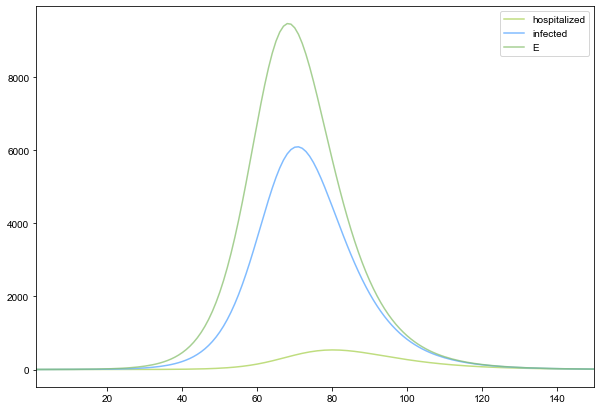

In [43]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
dm.loc[:,['hospitalized','infected','E']].plot(stacked=True,ax=ax)
print('Peak exposed:',dm['E'].max(),'at',dm['E'].idxmax())
print('Peak infections:',dm['infected'].max(),'at',dm['infected'].idxmax())
print('Peak hospitalizations:',dm['hospitalized'].max(),'at',dm['hospitalized'].idxmax())

![Calculator hospitalized](images/Epi-hospitalized.png)

## SIR approximation

11.72019552179324
R0: 2.94125
SIR R0: 2.5


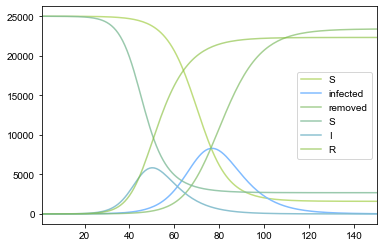

In [44]:
# import sympy as sp

# E = nx.contracted_nodes(E,'R','D')
source = ['E']
succ = []
prop = [1]
props = {}
period = [0]
periods = {}
while True:
    succ = []
    prop_copy = prop.copy()
    prop = []
    period_copy = period.copy()
    period = []
    for i,s in enumerate(source):
        ss = list(E.successors(s))
        if len(ss) == 0:
            try:
                props[s] = props[s] + prop_copy[i]
                periods[s] = periods[s] + period_copy[i]
            except KeyError:
                props[s] = prop_copy[i]
                periods[s] = period_copy[i]
        else:
            for l in ss:
                succ.append(l)
                prop.append(prop_copy[i]*P.edges[s,l,0]['label'])#sp.Symbol('P_{}{}'.format(s,l))
#                 print(s,l,P.edges[s,l,0]['label'])
                period.append(period_copy[i]+prop_copy[i]*P.edges[s,l,0]['label']*T.edges[s,l,0]['label'])#sp.Symbol('P_{}{}'.format(s,l))*sp.Symbol('T_{}{}'.format(s,l))
            
    if len(succ) == 0:
        break
#     print(succ)
#     print(prop)
#     print(period)
    source = succ

# print(props)
# print(periods)

source = 'E'
leaves = ['R','D']
props = {}
periods = {}
path_sum = {}
for l in leaves:
    l_period = 0
    l_prop = 0
    l_m = 0
    for path in nx.all_simple_paths(E,source,l):
        rev = path[::-1]
        eff = 0
        eff_p = 1
        p = 0
        for i in range(len(rev)-1):
            eff = P.edges[rev[i+1],rev[i],0]['label']*(eff + T.edges[rev[i+1],rev[i],0]['label'])
            eff_p = eff_p*P.edges[rev[i+1],rev[i],0]['label']
            p += T.edges[rev[i+1],rev[i],0]['label']
        l_period += eff
        l_prop += eff_p
        l_m += eff_p*p
    props[l] = l_prop
    periods[l] = l_period
    path_sum[l] = l_m
    
# assert sum(prop) == 1
# print(props)
# print(periods)
# print(path_sum)

# print(props['R']*periods['R']+props['D']*periods['D'])
print(props['R']*path_sum['R']+props['D']*path_sum['D'])
# print(path_sum['R']+path_sum['D'])
# pydot = nx.nx_pydot.to_pydot(E)
# pydot.set_graph_defaults()#rankdir = "LR"
# display(Source(pydot))

beta = 0.5
days=150

MODEL = BEM()
# infections
# MODEL.add_interaction('S', 'E', 'E', lambda t: beta)
MODEL.add_interaction('S', 'E', 'A', lambda t: other_parameters['asymptomatic infectiousness ratio']['mean']*beta)
MODEL.add_interaction('S', 'E', 'Ip', lambda t: beta)
MODEL.add_interaction('S', 'E', 'Im', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'Is', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'H1', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'H2', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'H3', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'ICU1', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'ICU2', lambda t: beta)
# infected compartments
for source,target,i in P.edges:
#     print(source,target,i)
#     f = lambda t, source=source,target=target: P.edges[source,target,0]['label']/T.edges[source,target,0]['label']
#     print(f(0))
    v = P.edges[source,target,0]['label']/(T.edges[source,target,0]['label'])#
    MODEL.add_flow(source,target,lambda t,v=v: v)

dfe = {'S':N, 'E':0, 'A':0, 'Ip':0, 'Im':0, 'Is':0, 'H1':0, 'H2':0, 'H3':0, 'ICU1':0, 'ICU2':0, 'R':0, 'D':0}
R0 = MODEL.R0(0,dfe)
print('R0:',R0)

SIR = BEM()
SIR.add_interaction('S', 'I', 'I', lambda t: 2.5/7)#R0/((props['R']*path_sum['R']+props['D']*path_sum['D'])))
SIR.add_flow('I','R',lambda t: 1/7)#/(props['R']*path_sum['R']+props['D']*path_sum['D']))#(props['R']*periods['R']+props['D']*periods['D'])+1


N = 25000
I0 = 1
initial_values = {'S':N-I0, 'E':I0, 'A':0, 'Ip':0, 'Im':0, 'Is':0, 'H1':0, 'H2':0, 'H3':0, 'ICU1':0, 'ICU2':0, 'R':0, 'D':0}

MODEL.integrate(days, **initial_values)
dm = MODEL.values_
dm['infected'] = dm.loc[:,['E','A','Ip','Im','Is','H1','H2','H3','ICU1','ICU2']].sum(axis=1)
dm['removed'] = dm.loc[:,['R','D']].sum(axis=1)

ax = plt.gca()
dm.loc[:,['S','infected','removed']].plot(ax=ax)

initial_values = {'S':N-I0, 'I':I0, 'R':0}
SIR.integrate(days, **initial_values)
ds = SIR.values_
dfe = {'S':N, 'I':0, 'R':0}
print('SIR R0:',SIR.R0(0,dfe))
ds.plot(ax=ax)


## SEIR approximation


R0: 2.94125
Incubation period: 4.0
Effective infectious period: 6.67
Case fatality rate: 0.514866 %
Average time till death after incubation period: 16.57723368798872
SEIR R0: 2.94125


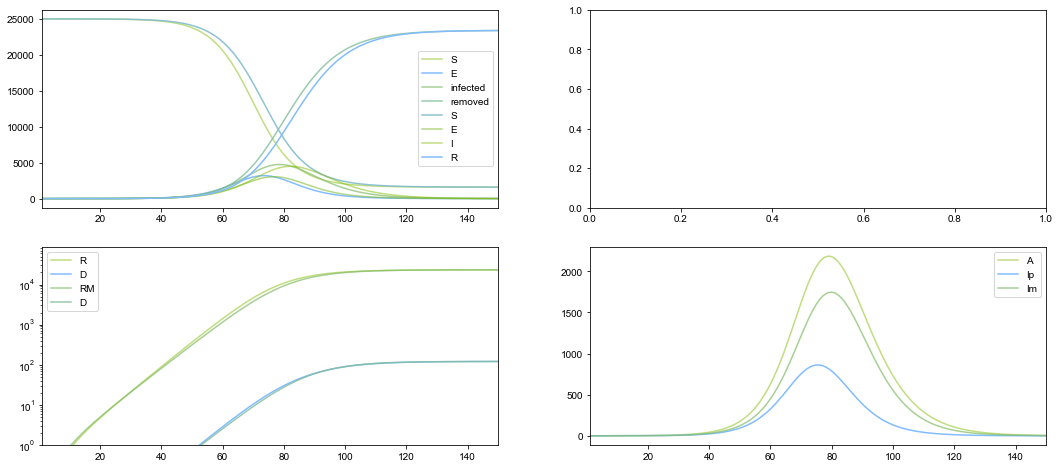

In [45]:
beta = 0.5
days = 150
N = 25000
dfe = {'S':N, 'E':0, 'A':0, 'Ip':0, 'Im':0, 'Is':0, 'H1':0, 'H2':0, 'H3':0, 'ICU1':0, 'ICU2':0, 'R':0, 'D':0}

MODEL = BEM()
# infections
MODEL.add_interaction('S', 'E', 'A', lambda t: other_parameters['asymptomatic infectiousness ratio']['mean']*beta)
MODEL.add_interaction('S', 'E', 'Ip', lambda t: beta)
MODEL.add_interaction('S', 'E', 'Im', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'Is', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'H1', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'H2', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'H3', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'ICU1', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'ICU2', lambda t: beta)
# infected compartments
for source,target,i in P.edges:
#     print(source,target,i)
#     f = lambda t, source=source,target=target: P.edges[source,target,0]['label']/T.edges[source,target,0]['label']
#     print(f(0))
#     v = P.edges[source,target,0]['label']/(T.edges[source,target,0]['label'])
#     MODEL.add_flow(source,target,lambda t,v=v: v)
    p = P.edges[source,target,0]['label']
    t = T.edges[source,target,0]['label']
    MODEL.add_flow(source,target, lambda time,p=p: p, lambda time,t=t: t)
R0 = MODEL.R0(0,dfe)
print('R0:', R0)

E2A_p,E2A_t = MODEL.proportion_period('E','A')
E2Ip_p,E2Ip_t = MODEL.proportion_period('E','Ip')
exposed_period = E2A_p*E2A_t+E2Ip_p*E2Ip_t
print('Incubation period:', exposed_period)
A2R_p, A2R_t = MODEL.proportion_period('A','R')
Ip2Is_p, Ip2Is_t = MODEL.proportion_period('Ip','Is')
Ip2Im_p, Ip2Im_t = MODEL.proportion_period('Ip','Im')
Im2R_p, Im2R_t = MODEL.proportion_period('Im','R')
infected_period = E2A_p*A2R_t+E2Ip_p*(Ip2Is_p*Ip2Is_t+Ip2Im_p*(Ip2Im_t+Im2R_t))
print('Effective infectious period:', infected_period)
E2D_p,E2D_t = MODEL.proportion_period('E','D')
print('Case fatality rate:',E2D_p*100,'%')
Ip2D_p, Ip2D_t = MODEL.proportion_period('Ip','D')
print('Average time till death after incubation period:', Ip2D_t)

SEIR = BEM()
SEIR.add_interaction('S', 'E', 'I', lambda t: R0/infected_period)
SEIR.add_flow('E','I',lambda t: 1/(exposed_period))#(props['R']*periods['R']+props['D']*periods['D'])
SEIR.add_flow('I','R',lambda t: 1/(infected_period))#(props['R']*periods['R']+props['D']*periods['D'])


N = 25000
I0 = 1
initial_values = {'S':N-I0, 'E':I0, 'A':0, 'Ip':0, 'Im':0, 'Is':0, 'H1':0, 'H2':0, 'H3':0, 'ICU1':0, 'ICU2':0, 'R':0, 'D':0}

MODEL.integrate(days, **initial_values)
dm = MODEL.values_
dm['infected'] = dm.loc[:,['A','Ip','Im']].sum(axis=1)#,'Is','H1','H2','H3','ICU1','ICU2'
dm['removed'] = dm.loc[:,['R','D']].sum(axis=1)


fig,ax = plt.subplots(2,2,figsize=(18,8))

dm.loc[:,['S','E','infected','removed']].plot(ax=ax[0,0])
dm['Ip_s'] = dm.loc[:,['Ip','Im','Is','H1','H2','H3','ICU1','ICU2']].sum(axis=1)
dm.loc[:,['R','D']].plot(logy=True,ax=ax[1,0])
ax[1,0].set_ylim(1)
dm.loc[:,['A','Ip','Im']].plot(ax=ax[1,1])

initial_values = {'S':N-I0, 'E':I0, 'I':0, 'R':0}
SEIR.integrate(days, **initial_values)
ds = SEIR.values_
dfe = {'S':N, 'E':0, 'I':0, 'R':0}
print('SEIR R0:',SEIR.R0(0,dfe))
ds.plot(ax=ax[0,0])

# ds['RM'] = ds['R']*(props['A']['R']*P.edges['E','A',0]['label']+props['Ip']['R']*P.edges['E','Ip',0]['label'])
# D = ds['R']*(props['A']['D']*P.edges['E','A',0]['label']+props['Ip']['D']*P.edges['E','Ip',0]['label'])
D = ds['R']*E2D_p
shifted_index = ds.index+infected_period#(path_sum['Ip']['D']/(props['Ip']['D']*P.edges['E','Ip',0]['label']))
D.index = shifted_index
ds['D'] = D.reindex(ds.index.union(shifted_index)).interpolate(method='index').reindex(ds.index).fillna(0)
# ds['D'] = D
ds['RM'] = ds['R']-ds['D']
# print(ds['RM'].head(50))
ds.loc[:,['RM','D']].plot(logy=True,ax=ax[1,0])

# ds['A'] = (ds['I']*P.edges['E','A',0]['label'])#/T.edges['E','A',0]['label']#.reindex(ds.index.union(ds.index+T.edges['E','A',0]['label'])).interpolate(method='index').reindex(ds.index).fillna(method='bfill')
# ds['Ip'] = ds['I']*P.edges['E','Ip',0]['label']/3#/T.edges['E','Ip',0]['label']
# ds['Im'] = ds['Ip']*P.edges['Ip','Im',0]['label']#/T.edges['Ip','Im',0]['label']
# ds.loc[:,['A','Ip','Im']].plot(ax=ax[0,1])#,'Ip'


# Start date


Incubation period: 4.0
Effective infectious period: 6.67
Case fatality rate: 0.514866 %
Optimizing for start date: 2020-02-13 00:00:00
Optimizing for start date: 2020-02-14 00:00:00
Optimizing for start date: 2020-02-15 00:00:00
Optimizing for start date: 2020-02-16 00:00:00
Optimizing for start date: 2020-02-17 00:00:00
Optimizing for start date: 2020-02-18 00:00:00
Optimizing for start date: 2020-02-19 00:00:00
Optimizing for start date: 2020-02-20 00:00:00
Optimizing for start date: 2020-02-21 00:00:00
Optimizing for start date: 2020-02-22 00:00:00
Optimizing for start date: 2020-02-23 00:00:00
Optimizing for start date: 2020-02-24 00:00:00
Optimizing for start date: 2020-02-25 00:00:00
Optimizing for start date: 2020-02-26 00:00:00
Optimizing for start date: 2020-02-27 00:00:00
Optimizing for start date: 2020-02-28 00:00:00
Optimizing for start date: 2020-02-29 00:00:00
Optimizing for start date: 2020-03-01 00:00:00
Optimizing for start date: 2020-03-02 00:00:00
Optimizing for star

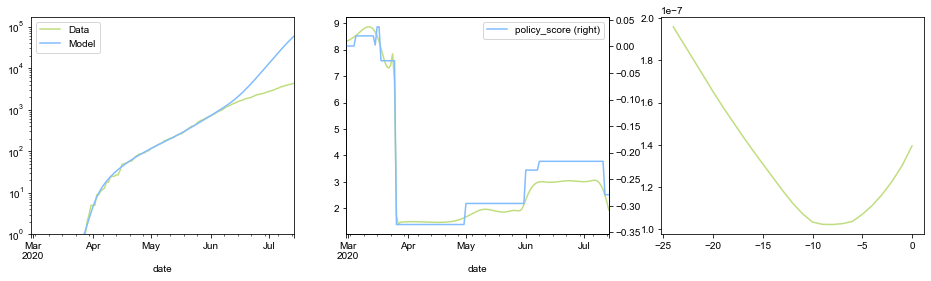

In [46]:
df,info = get('South Africa')
N = info['population']

# fit through policy score

index = df.index
x = index.map(lambda t: (t-index[0]).days)
policy_spline = UnivariateSpline(x,df['policy_score'][index],s=0.01,ext=3)

# days

data_start_date = df.index[0]
confirmed_date = (df.confirmed > 1).idxmax()
end_date = pd.to_datetime('2020-06-10')

# usefull functions for optimization

def sigmoid1(x):  
    return 2*(np.exp(-np.logaddexp(0, -x*2))-0.5)

def sigmoid1_inv(y):
    return -0.5*np.log(1/(y*0.5+0.5)-1)

# optimization scaling

scale = {
    'beta': lambda x: x**2,
    'mobility_effect': lambda x: x**2,
}

scale_inv = {
    'beta': lambda x: x**0.5,
    'mobility_effect': lambda x: x**0.5,
}
def scale_fun(d):
    new_d = {}
    for k in d:
        try:
            new_d[k] = scale[k](d[k])
        except KeyError:
            new_d[k] = d[k]
    return new_d

def scale_inv_fun(d):
    new_d = {}
    for k in d:
        try:
            new_d[k] = scale_inv[k](d[k])
        except KeyError:
            new_d[k] = d[k]
    return new_d

# get effective SEIR model

MODEL = BEM()
MODEL.add_interaction('S', 'E', 'A', lambda t: other_parameters['asymptomatic infectiousness ratio']['mean']*beta)
MODEL.add_interaction('S', 'E', 'Ip', lambda t: beta)
MODEL.add_interaction('S', 'E', 'Im', lambda t: beta)
for source,target,i in P.edges:
    p = P.edges[source,target,0]['label']
    t = T.edges[source,target,0]['label']
    MODEL.add_flow(source,target, lambda time,p=p: p, lambda time,t=t: t)

E2A_p,E2A_t = MODEL.proportion_period('E','A')
E2Ip_p,E2Ip_t = MODEL.proportion_period('E','Ip')
exposed_period = E2A_p*E2A_t+E2Ip_p*E2Ip_t
print('Incubation period:', exposed_period)

A2R_p, A2R_t = MODEL.proportion_period('A','R')
Ip2Is_p, Ip2Is_t = MODEL.proportion_period('Ip','Is')
Ip2Im_p, Ip2Im_t = MODEL.proportion_period('Ip','Im')
Im2R_p, Im2R_t = MODEL.proportion_period('Im','R')
infected_period = E2A_p*A2R_t+E2Ip_p*(Ip2Is_p*Ip2Is_t+Ip2Im_p*(Ip2Im_t+Im2R_t))
print('Effective infectious period:', infected_period)

E2D_p,E2D_t = MODEL.proportion_period('E','D')
print('Case fatality rate:',E2D_p*100,'%')

# Ip2D_p, Ip2D_t = MODEL.proportion_period('Ip','D')
# print('Average time till death after incubation period:', Ip2D_t)


def MODEL_DATA(model_parameters, initial_values, start_date,end_date=end_date):
    days = (end_date-start_date).days+1
    model_parameters = scale_fun(model_parameters)

    def beta(time):
        t = (start_date-data_start_date).days+time
        return model_parameters['beta'] * (1+sigmoid1(policy_spline(t)*model_parameters['mobility_effect']))


    SEIR = BEM()
    SEIR.add_interaction('S', 'E', 'I', beta)
    SEIR.add_flow('E','I',lambda t: 1/(exposed_period))#(props['R']*periods['R']+props['D']*periods['D'])
    SEIR.add_flow('I','R',lambda t: 1/(infected_period))#(props['R']*periods['R']+props['D']*periods['D'])

    SEIR.integrate(days, **initial_values)
    ds = SEIR.values_
    # Calculate deaths
    D = ds['R']*E2D_p
    shifted_index = ds.index+infected_period
    D.index = shifted_index
    ds['D'] = D.reindex(ds.index.union(shifted_index)).interpolate(method='index').reindex(ds.index).fillna(0)#method='bfill'
#     ds['RM'] = ds['R']-ds['D']
    
    dfe = {'S':N, 'E':0, 'I':0, 'R':0}
    R0 = pd.Series([SEIR.R0(i,dfe) for i in range(days)],index=ds.index)
    ds['R0'] = R0
    ds.index = pd.date_range(start=start_date,periods=days,freq='D')
    return ds
    
# optimize
model_parameters = {
    'beta': 0.3726944212132001, 
    'mobility_effect': 1.0289847129028033,
}

initial_values = {'S':N-I0, 'E':I0, 'I':0, 'R':0}
ops = []
errs = []
start_days = list(range(-24,1))

# # check initial conditions
# start_date = confirmed_date+pd.to_timedelta(start_days[0],unit='D')
# dm = MODEL_DATA(scale_inv_fun(model_parameters),initial_values,start_date=start_date)
# data = df.loc[start_date:end_date,:]
# fig,ax = plt.subplots(1,2,figsize=(14,4))
# data.loc[:,'D'].plot(logy=True,ax=ax[0])
# dm.loc[:,'D'].plot(ax=ax[0])
# ax[0].legend(['Data','Model'])
# ax[0].set_ylim(1)
# dm.loc[:,'R0'].plot(ax=ax[1])
# data.loc[:,['policy_score']].plot(secondary_y=True,ax=ax[1])#,'mobility_score'


for start_day in start_days:#-20
    start_date = confirmed_date+pd.to_timedelta(start_day,unit='D')
    print('Optimizing for start date:',start_date)
    cm = calibrate(model_data=lambda m,i: MODEL_DATA(m,i,start_date=start_date), data = df.loc[start_date:end_date,['D']],
                   initial_values=initial_values, 
                   parameter_keys=model_parameters.keys(), 
                   N = N, scaled=True, log=False, relative=True)#, weights=functio
    za_op, result = cm.calibrate(dict_to_array(scale_inv_fun(model_parameters))*2*np.random.random(2), method='Nelder-Mead') 
#     print(scale_fun(za_op))
#     print(result)
    ops.append(za_op)
    errs.append(result.fun)
print(errs)
i = errs.index(min(errs))
print('Days from first infection:',start_days[i])
za_op = ops[i]
# za_op, result = cm.calibrate(dict_to_array(optimization_params), method='Nelder-Mead') 
# za_op = optimization_params
print('Initial guess:',model_parameters)
print('Optimal:',scale_fun(za_op))
model_parameters.update(scale_fun(za_op))

start_date = confirmed_date+pd.to_timedelta(start_days[i],unit='D')
print('Start date:',start_date)
print('Days since first death:',(start_date-(df.D > 1).idxmax()).days)
print('Days since 10 deaths:',(start_date-(df.D > 10).idxmax()).days)
final_date = df.index[-1]
dm = MODEL_DATA(scale_inv_fun(model_parameters),initial_values,start_date=start_date,end_date=final_date)
data = df.loc[start_date:final_date,:]
fig,ax = plt.subplots(1,3,figsize=(16,4))
data.loc[:,'D'].plot(logy=True,ax=ax[0])
dm.loc[:,'D'].plot(ax=ax[0])
ax[0].legend(['Data','Model'])
ax[0].set_ylim(1)
dm.loc[:,'R0'].plot(ax=ax[1])
data.loc[:,['policy_score']].plot(secondary_y=True,ax=ax[1])#,'mobility_score'
ax[2].plot(start_days,errs)

# beta from R0

[5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825
 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825
 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825
 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825
 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825
 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825
 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825
 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825
 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825
 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825 5.8825]


2.728394767059772e-14

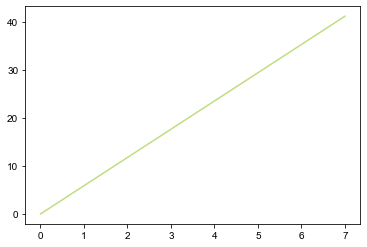

In [47]:
beta = 0.5
days = 150
N = 25000
dfe = {'S':N, 'E':0, 'A':0, 'Ip':0, 'Im':0, 'Is':0, 'H1':0, 'H2':0, 'H3':0, 'ICU1':0, 'ICU2':0, 'R':0, 'D':0}


MODEL = BEM()
# infections
MODEL.add_interaction('S', 'E', 'A', lambda t: other_parameters['asymptomatic infectiousness ratio']['mean']*beta)
MODEL.add_interaction('S', 'E', 'Ip', lambda t: beta)
MODEL.add_interaction('S', 'E', 'Im', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'Is', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'H1', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'H2', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'H3', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'ICU1', lambda t: beta)
# MODEL.add_interaction('S', 'E', 'ICU2', lambda t: beta)
# infected compartments
for source,target,i in P.edges:
#     print(source,target,i)
#     f = lambda t, source=source,target=target: P.edges[source,target,0]['label']/T.edges[source,target,0]['label']
#     print(f(0))
#     v = P.edges[source,target,0]['label']/(T.edges[source,target,0]['label'])
#     MODEL.add_flow(source,target,lambda t,v=v: v)
    p = P.edges[source,target,0]['label']
    t = T.edges[source,target,0]['label']
    MODEL.add_flow(source,target, lambda time,p=p: p, lambda time,t=t: t)
betas = np.linspace(0.001,7,100)
R0s = []
for b in betas:
    beta = b
    R0s.append(MODEL.R0(0,dfe))
    
R0s = np.array(R0s)
plt.plot(betas,R0s)
print(R0s/betas)
np.sum(np.abs(R0s/(E2A_p*A2R_t*(other_parameters['asymptomatic infectiousness ratio']['mean'])+E2Ip_p*(Ip2Is_p*Ip2Is_t+Ip2Im_p*(Ip2Im_t+Im2R_t)))-betas))